# Predict whether S&P 500 will close higher or lower than yesterday

In this solution, you will:

* Obtain data for a number of financial markets.
* Wrangle that data into a usable format and perform exploratory data analysis in order to explore and validate a premise.
* Use TensorFlow on Cloud ML Engine to build, train and evaluate a number of models for predicting what will happen in financial markets

**Important:** This solution is intended to illustrate the capabilities of GCP and TensorFlow for fast, interactive, iterative data analysis and machine learning. It does not offer any advice on financial markets or trading strategies. The scenario presented in the tutorial is an example. Don't use this code to make investment decisions.

## Prerequisites
**Note:** You do not need to download and run your own copy of this notebook on Cloud Datalab to read and derive value, but if you want to make changes and experiment on your own, which is strongly encouraged, you will need to complete these prerequisites.

You can use your free $300 trial that Google Cloud provides for new accounts
* [Create a project](https://cloud.google.com/docs/overview/)
* [Enable billing for you project](https://console.developers.google.com/billing).
* [Launch Cloud Datalab for your project](https://cloud.google.com/datalab/getting-started)
* This notebook is included in the Cloud Datalab distribution in the ‘notebooks’ directory.  Simply open the notebook and proceed.

## The premise
The premise is straightforward: financial markets are increasingly global, and if you follow the sun from Asia to Europe to the US and so on, you can use information from an earlier time zone to your advantage in a later time zone.

The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close that index and the close of the S&P 500 in New York. This makes EST the base time zone. For example, Australian markets close for the day 15 hours before US markets close. If the close of the All Ords in Australia is a useful predictor of the close of the S&P 500 for a given day we can use that information to guide our trading activity. Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P 500 will close up as well then we should either buy stocks that compose the S&P 500 or, more likely, an ETF that tracks the S&P 500. In reality, the situation is more complex because there are commissions and tax to account for. But as a first approximation, we'll assume an index closing up indicates a gain, and vice-versa.

|Index|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|
|[FTSE 100](https://en.wikipedia.org/wiki/FTSE_100_Index)|UK|1130|4.5|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|

### Set Up: Imports (The packages already come installed with Datalab)

In [2]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
import tensorflow as tf

In [4]:
# Verify TensorFlow Version
print(tf.__version__)

1.0.0


### Get the Data from [BigQuery](https://cloud.google.com/bigquery) 

In [20]:
# Querying BigQuery to get data from Public dataset available on a public project (bingo-ml-1) with dataset named market_data
snp = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.snp`").execute().result().to_dataframe().set_index('Date')
nyse = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.nyse`").execute().result().to_dataframe().set_index('Date')
djia = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.djia`").execute().result().to_dataframe().set_index('Date')
nikkei = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.nikkei`").execute().result().to_dataframe().set_index('Date')
hangseng = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.hangseng`").execute().result().to_dataframe().set_index('Date')
ftse = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.ftse`").execute().result().to_dataframe().set_index('Date')
dax = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.dax`").execute().result().to_dataframe().set_index('Date')
aord = bq.Query("SELECT Date, Close FROM `bingo-ml-1.market_data.aord`").execute().result().to_dataframe().set_index('Date')

### Lets quickly take a peek at our data

In [21]:
snp['Close'].head()

Date
2014-01-28    1792.50
2012-10-24    1408.75
2012-03-19    1409.75
2011-06-23    1283.50
2012-06-05    1285.50
Name: Close, dtype: float64

## Munge the data
In the first instance, munging the data is straightforward. The closing prices are of interest, so for convenience extract the closing prices. Because not all of the indices have the same number of values, mainly due to bank holidays, we'll forward-fill the gaps. This means that, if a value isn't available for day N, fill it with the value for another day, such as N-1 or N-2, so that it contains the latest available value

In [22]:
closing_data = pd.DataFrame()

closing_data['snp_close'] = snp['Close']
closing_data['nyse_close'] = nyse['Close']
closing_data['djia_close'] = djia['Close']
closing_data['nikkei_close'] = nikkei['Close']
closing_data['hangseng_close'] = hangseng['Close']
closing_data['ftse_close'] = ftse['Close']
closing_data['dax_close'] = dax['Close']
closing_data['aord_close'] = aord['Close']

# Pandas includes a very convenient function for filling gaps in the data.
closing_data = closing_data.fillna(method='ffill')

## Explore our Data
Exploratory Data Analysis (EDA) is foundational to working with machine learning

In [23]:
closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,ftse_close,dax_close,aord_close
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1549.733275,8920.468489,14017.464990,12562.240032,22250.759871,6097.818589,7959.386910,4910.363302
std,338.278280,1420.830375,2522.948044,3653.294124,2024.991482,552.471781,1761.802671,486.961236
min,1022.580017,6434.810059,9686.480469,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098
25%,1271.239990,7668.234863,11987.635254,9463.864746,20850.485351,5677.849853,6448.355225,4483.199951
50%,1433.189941,8445.769531,13323.360352,10815.030273,22444.800781,6005.100098,7426.810059,4899.200195
75%,1875.510010,10370.324707,16413.575196,15215.709961,23447.339844,6620.699951,9403.629883,5345.750000
max,2130.820068,11239.660156,18312.390625,20868.029297,28442.750000,7104.000000,12374.730469,5954.799805


### Scale the data
You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index. Divide each value in an individual index by the maximum value for that index., and then plot. The maximum value of all indices will be 1.

In [25]:
closing_data['snp_close_scaled'] = closing_data['snp_close'] / max(closing_data['snp_close'])
closing_data['nyse_close_scaled'] = closing_data['nyse_close'] / max(closing_data['nyse_close'])
closing_data['djia_close_scaled'] = closing_data['djia_close'] / max(closing_data['djia_close'])
closing_data['nikkei_close_scaled'] = closing_data['nikkei_close'] / max(closing_data['nikkei_close'])
closing_data['hangseng_close_scaled'] = closing_data['hangseng_close'] / max(closing_data['hangseng_close'])
closing_data['ftse_close_scaled'] = closing_data['ftse_close'] / max(closing_data['ftse_close'])
closing_data['dax_close_scaled'] = closing_data['dax_close'] / max(closing_data['dax_close'])
closing_data['aord_close_scaled'] = closing_data['aord_close'] / max(closing_data['aord_close'])

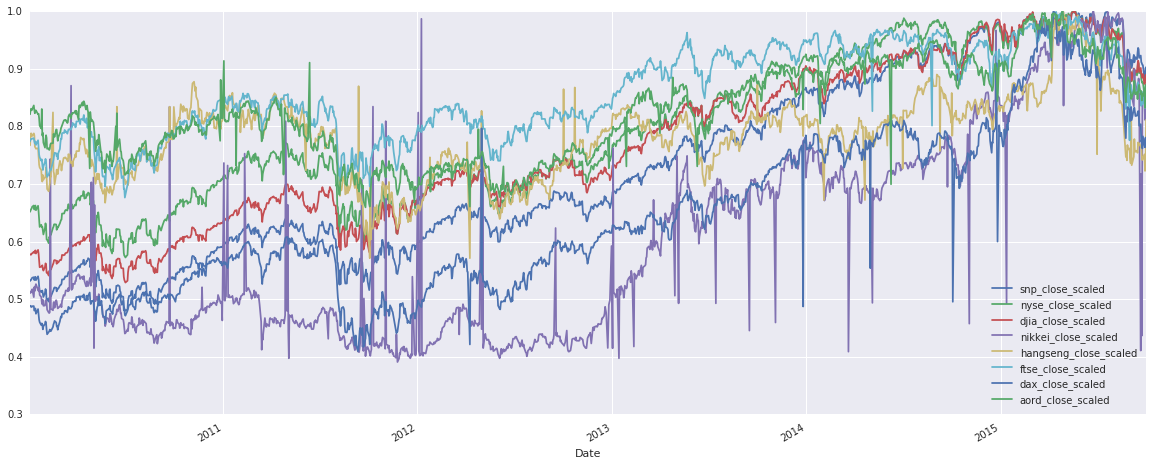

In [69]:
_ = pd.concat([closing_data['snp_close_scaled'],
  closing_data['nyse_close_scaled'],
  closing_data['djia_close_scaled'],
  closing_data['nikkei_close_scaled'],
  closing_data['hangseng_close_scaled'],
  closing_data['ftse_close_scaled'],
  closing_data['dax_close_scaled'],
  closing_data['aord_close_scaled']], axis=1).plot(figsize=(20, 8))

You can see that, over the five-year period, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises.

### Stationary Timeseries with no Trends
The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

`ln(Vt/Vt-1)`

There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [67]:
log_return_data = pd.DataFrame()

log_return_data['snp_log_return'] = np.log(closing_data['snp_close']/closing_data['snp_close'].shift())
log_return_data['nyse_log_return'] = np.log(closing_data['nyse_close']/closing_data['nyse_close'].shift())
log_return_data['djia_log_return'] = np.log(closing_data['djia_close']/closing_data['djia_close'].shift())
log_return_data['nikkei_log_return'] = np.log(closing_data['nikkei_close']/closing_data['nikkei_close'].shift())
log_return_data['hangseng_log_return'] = np.log(closing_data['hangseng_close']/closing_data['hangseng_close'].shift())
log_return_data['ftse_log_return'] = np.log(closing_data['ftse_close']/closing_data['ftse_close'].shift())
log_return_data['dax_log_return'] = np.log(closing_data['dax_close']/closing_data['dax_close'].shift())
log_return_data['aord_log_return'] = np.log(closing_data['aord_close']/closing_data['aord_close'].shift())

log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,ftse_log_return,dax_log_return,aord_log_return
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,-0.000388,-0.000309,-0.000344,-0.000337,-0.000068,-0.000212,-0.000330,-0.000135
std,0.283236,0.209795,0.238571,0.342093,0.116175,0.122537,0.273648,0.129086
min,-0.692658,-0.506502,-0.600737,-0.870563,-0.457791,-0.326003,-0.787802,-0.364802
25%,-0.192233,-0.140085,-0.164099,-0.164568,-0.067824,-0.085775,-0.181835,-0.081770
50%,0.001868,0.002654,0.005476,0.000000,0.000000,0.000000,0.004398,0.000000
75%,0.172184,0.141786,0.151943,0.185417,0.074022,0.084336,0.178776,0.086402
max,0.694100,0.504759,0.608545,0.879570,0.356832,0.310955,0.733355,0.351090


You now have time series for the indices, stationary in the mean, similarly centered and scaled. That's great! Now start to look for signals to try to predict the close of the S&P 500.

### Scatter Plot 

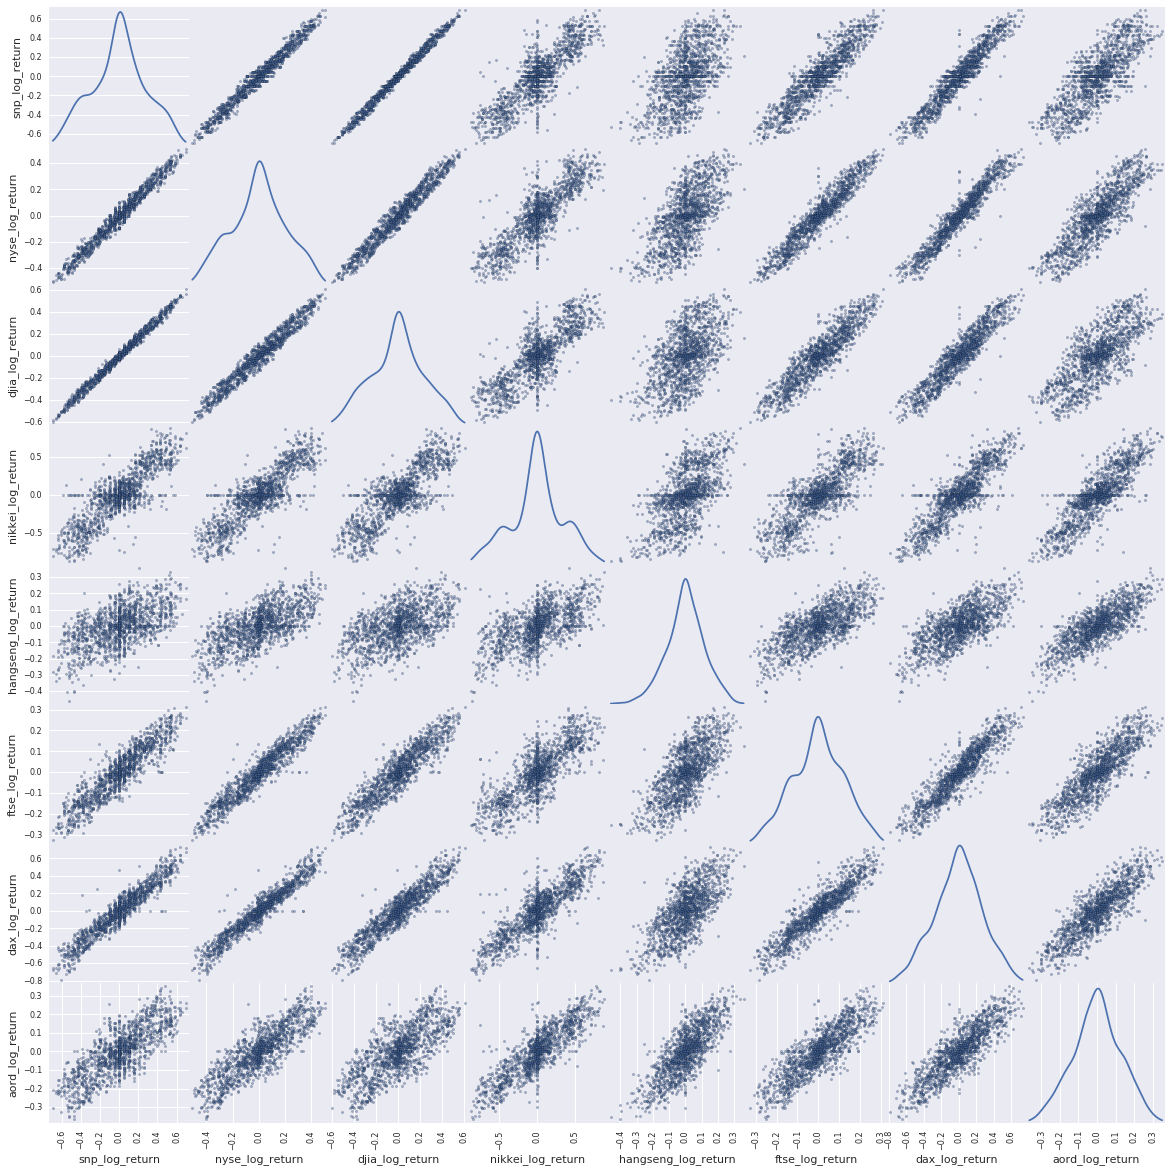

In [68]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

## Summary of our Exploratory Data Analysis

At this point, you've done a good enough job of exploratory data analysis. You've visualized our data and come to know it better. You've transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. You've seen that indices from Europe strongly correlate with US indices, and that indices from Asia/Oceania significantly correlate with those same indices for a given day. You've also seen that if you look at historical values, they do not correlate with today's values. Summing up:

* European indices from the same day were a strong predictor for the S&P 500 close.
* Asian/Oceanian indices from the same day were a significant predictor for the S&P 500 close.
* Indices from previous days were not good predictors for the S&P close.

What should we think so far?

Cloud Datalab is working great. With just a few lines of code, you were able to munge the data, visualize the changes, and make decisions. You could easily analyze and iterate. This is a common feature of iPython, but the advantage here is that Cloud Datalab is a managed service that you can simply click and use, so you can focus on your analysis.

# Machine Learning - Predict S&P 500 close today will be higher or lower than yesterday

At this point, we can see a model:

* We'll predict whether the S&P 500 close today will be higher or lower than yesterday.
* We'll use all our data sources: NYSE, DJIA, Nikkei, Hang Seng, FTSE, DAX, AORD.
* We'll use three sets of data points —  T, T-1, and T-2 — where we take the data available on day T or T-n, meaning today's non-US data and yesterday's US data.

Predicting whether the log return of the S&P 500 is positive or negative is a classification problem. That is, we want to choose one option from a finite set of options, in this case positive or negative. This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

This uses the findings from of our exploratory data analysis, namely that log returns from other regions on a given day are strongly correlated with the log return of the S&P 500, and there are stronger correlations from those regions that are geographically closer with respect to time zones. However, our models also use data outside of those findings. For example, we use data from the past few days in addition to today.  There are two reasons for using this additional data. First, we're adding additional features to our model for the purpose of this solution to see how things perform. which is not a good reason to add features outside of a tutorial setting. Second, machine learning models are very good at finding weak signals from data.

In machine learning, as in most things, there are subtle tradeoffs happening, but in general good data is better than good algorithms, which are better than good frameworks. You need all three pillars but in that order of importance: data, algorithms, frameworks.

## TensorFlow
[TensorFlow](https://tensorflow.org) is an open source software library, initiated by Google, for numerical computation using data flow graphs. TensorFlow is based on Google's machine learning expertise and is the next generation framework used internally at Google for tasks such as translation and image recognition. It's a wonderful framework for machine learning because it's expressive, efficient, and easy to use.

### Feature engineering for [TensorFlow](https://www.tensorflow.org/)
From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time.  Otherwise,  your model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because you can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Decide on a training-versus-testing split, and divide your data into training and test datasets.

In this case, you'll create the features together with two additional columns:

*  snp_log_return_positive, which is 1 if the log return of the S&P 500 close is positive, and 0 otherwise. 
* snp_log_return_negative, which is 1 if the log return of the S&P 500 close is negative, and 1 otherwise. 

## Prepare our Input Data to TensorFlow

In [33]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.ix[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.ix[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(
  columns=[
    'snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

for i in range(7, len(log_return_data)):
  snp_log_return_positive = log_return_data['snp_log_return_positive'].ix[i]
  snp_log_return_negative = log_return_data['snp_log_return_negative'].ix[i]
  snp_log_return_1 = log_return_data['snp_log_return'].ix[i-1]
  snp_log_return_2 = log_return_data['snp_log_return'].ix[i-2]
  snp_log_return_3 = log_return_data['snp_log_return'].ix[i-3]
  nyse_log_return_1 = log_return_data['nyse_log_return'].ix[i-1]
  nyse_log_return_2 = log_return_data['nyse_log_return'].ix[i-2]
  nyse_log_return_3 = log_return_data['nyse_log_return'].ix[i-3]
  djia_log_return_1 = log_return_data['djia_log_return'].ix[i-1]
  djia_log_return_2 = log_return_data['djia_log_return'].ix[i-2]
  djia_log_return_3 = log_return_data['djia_log_return'].ix[i-3]
  nikkei_log_return_0 = log_return_data['nikkei_log_return'].ix[i]
  nikkei_log_return_1 = log_return_data['nikkei_log_return'].ix[i-1]
  nikkei_log_return_2 = log_return_data['nikkei_log_return'].ix[i-2]
  hangseng_log_return_0 = log_return_data['hangseng_log_return'].ix[i]
  hangseng_log_return_1 = log_return_data['hangseng_log_return'].ix[i-1]
  hangseng_log_return_2 = log_return_data['hangseng_log_return'].ix[i-2]
  ftse_log_return_0 = log_return_data['ftse_log_return'].ix[i]
  ftse_log_return_1 = log_return_data['ftse_log_return'].ix[i-1]
  ftse_log_return_2 = log_return_data['ftse_log_return'].ix[i-2]
  dax_log_return_0 = log_return_data['dax_log_return'].ix[i]
  dax_log_return_1 = log_return_data['dax_log_return'].ix[i-1]
  dax_log_return_2 = log_return_data['dax_log_return'].ix[i-2]
  aord_log_return_0 = log_return_data['aord_log_return'].ix[i]
  aord_log_return_1 = log_return_data['aord_log_return'].ix[i-1]
  aord_log_return_2 = log_return_data['aord_log_return'].ix[i-2]
  training_test_data = training_test_data.append(
    {'snp_log_return_positive':snp_log_return_positive,
    'snp_log_return_negative':snp_log_return_negative,
    'snp_log_return_1':snp_log_return_1,
    'snp_log_return_2':snp_log_return_2,
    'snp_log_return_3':snp_log_return_3,
    'nyse_log_return_1':nyse_log_return_1,
    'nyse_log_return_2':nyse_log_return_2,
    'nyse_log_return_3':nyse_log_return_3,
    'djia_log_return_1':djia_log_return_1,
    'djia_log_return_2':djia_log_return_2,
    'djia_log_return_3':djia_log_return_3,
    'nikkei_log_return_0':nikkei_log_return_0,
    'nikkei_log_return_1':nikkei_log_return_1,
    'nikkei_log_return_2':nikkei_log_return_2,
    'hangseng_log_return_0':hangseng_log_return_0,
    'hangseng_log_return_1':hangseng_log_return_1,
    'hangseng_log_return_2':hangseng_log_return_2,
    'ftse_log_return_0':ftse_log_return_0,
    'ftse_log_return_1':ftse_log_return_1,
    'ftse_log_return_2':ftse_log_return_2,
    'dax_log_return_0':dax_log_return_0,
    'dax_log_return_1':dax_log_return_1,
    'dax_log_return_2':dax_log_return_2,
    'aord_log_return_0':aord_log_return_0,
    'aord_log_return_1':aord_log_return_1,
    'aord_log_return_2':aord_log_return_2},
    ignore_index=True)

## Split our Data for Training & Testing
We'll use 80% of our data for training and 20% for testing.

In [38]:
training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size
data_train = training_test_data[:training_set_size]
data_test = training_test_data[training_set_size:]
print "Training Data Matrix:",data_train.shape
print "Testing Data Matrix:",data_test.shape

Training Data Matrix: (1152, 26)
Testing Data Matrix: (288, 26)


## Data Staging Prep

In [3]:
GCS_BUCKET = 'gs://stock_indices_snp_prediction' #CHANGE THIS TO YOUR BUCKET
PROJECT = 'indigo-bloom-118922' #CHANGE THIS TO YOUR PROJECT ID
REGION = 'us-central1' #OPTIONALLY CHANGE THIS
import os
os.environ['GCS_BUCKET'] = GCS_BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [61]:
data_train.to_csv("snp_train.csv", header=False)
data_test.to_csv("snp_test.csv", header=False)

#TODO: "header = false" works only for string headers for pandas
!sed -i '1d' snp_train.csv # Dropping the header line of the CSV since header = false is failing
!sed -i '1d' snp_test.csv  # Dropping the header line of the CSV 

!gsutil cp snp_train.csv snp_test.csv $GCS_BUCKET

Copying file://snp_train.csv [Content-Type=text/csv]...
Copying file://snp_test.csv [Content-Type=text/csv]...
-
Operation completed over 2 objects/550.5 KiB.                                    


## Building a Machine Learning Model with TensorFlow

In [51]:
%%bash
mkdir trainer
touch trainer/__init__.py

mkdir: cannot create directory 'trainer': File exists


In [74]:
%%writefile trainer/task.py

import argparse
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
from tensorflow.contrib.learn.python.learn.utils import input_fn_utils

tf.logging.set_verbosity(tf.logging.ERROR)


data_train = pd.read_csv(
  filepath_or_buffer= 'https://storage.googleapis.com/stock_indices_snp_prediction/snp_train.csv',
  names=['snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

data_test = pd.read_csv(
  filepath_or_buffer= 'https://storage.googleapis.com/stock_indices_snp_prediction/snp_test.csv',
  names=['snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

FEATURES = [
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2']

#LABELS = ['snp_log_return_positive','snp_log_return_negative']
LABEL = 'snp_log_return_positive'

feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

def generate_estimator(output_dir):
  return tf.contrib.learn.DNNClassifier(feature_columns=feature_cols,
                                            hidden_units=[50, 25],
                                            model_dir=output_dir)

def generate_input_fn(data_set):
    def input_fn():
      features = {k: tf.constant(data_set[k].values) for k in FEATURES}
      #labels = {l: tf.constant(data_set[l].values) for l in LABELS}
      labels = tf.constant(data_set[LABEL].values)
      return features, labels
    return input_fn

def serving_input_fn():
  feature_placeholders = {
      column.name: tf.placeholder(column.dtype, [None])
      for column in feature_cols
  }
  # DNNCombinedLinearClassifier expects rank 2 Tensors, but inputs should be
  # rank 1, so that we can provide scalars to the server
  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }
  return input_fn_utils.InputFnOps(
    features,
    None,
    feature_placeholders
  )

def generate_experiment_fn(output_dir):
  return tf.contrib.learn.Experiment(
    generate_estimator(output_dir),
    train_input_fn=generate_input_fn(data_train), 
    eval_input_fn=generate_input_fn(data_test), 
    export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
        )],
    train_steps=3000,
    eval_steps=5000
  )

######CLOUD ML ENGINE BOILERPLATE CODE BELOW######
if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  # Input Arguments
  parser.add_argument(
      '--output_dir',
      help='GCS location to write checkpoints and export models',
      required=True
  )
  parser.add_argument(
        '--job-dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
    )
  args = parser.parse_args()
  arguments = args.__dict__
  output_dir = arguments.pop('output_dir')

  learn_runner.run(generate_experiment_fn, output_dir)

Overwriting trainer/task.py


## Train Locally to test

In [62]:
%%bash
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=trainer \
   -- \
   --output_dir='./output_snp'

W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE3 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.


## Train via GPUs on Cloud ML Engine

In [75]:
%%bash
JOBNAME=snp_predict_$(date -u +%y%m%d_%H%M%S)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=./trainer \
   --job-dir=$GCS_BUCKET/$JOBNAME \
   --scale-tier=BASIC_GPU \
   -- \
   --output_dir=$GCS_BUCKET/$JOBNAME/output

jobId: snp_predict_170801_183308
state: QUEUED


Job [snp_predict_170801_183308] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe snp_predict_170801_183308

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs snp_predict_170801_183308


## Running on 8 GPUs
To train across multiple GPUs you use a [custom scale tier](https://cloud.google.com/ml-engine/docs/concepts/training-overview#job_configuration_parameters). Here I am specifying a master node with machine type complex_model_m_gpu and one worker node of the same type. Each complex_model_m_gpu has 4 GPUs so this job will run on 2x4=8 GPUs total.

In [76]:
%%writefile config.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: complex_model_m_gpu
  workerType: complex_model_m_gpu
  workerCount: 1

Writing config.yaml


In [ ]:
%%bash
JOBNAME=housing_$(date -u +%y%m%d_%H%M%S)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=./trainer \
   --job-dir=$GCS_BUCKET/$JOBNAME \
   --config config.yaml \
   -- \
   --output_dir=$GCS_BUCKET/$JOBNAME/output

## TensorBoard - View our Training Progress

In [85]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://stock_indices_snp_prediction/snp_predict_170801_183308/output')

TensorBoard was started successfully with pid 31486. Click here to access it.

31486

In [79]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print 'Stopped TensorBoard with pid {}'.format(pid)

Stopped TensorBoard with pid 27410


## Deploying the Model to CloudML Engine

In [82]:
%%bash
MODEL_NAME="snp_predict"
MODEL_VERSION="v1"
MODEL_LOCATION="gs://stock_indices_snp_prediction/snp_predict_170801_183308/output/export/Servo/1501613505526" #REPLACE this with the location of your model

#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME} #Uncomment to overwrite existing version
#gcloud ml-engine models delete ${MODEL_NAME} #Uncomment to overwrite existing model
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --staging-bucket=$GCS_BUCKET

Creating version (this might take a few minutes)......
...............................................................................done.


## Predicting SnP Index via REST API 

In [83]:
%%writefile records.json
{"snp_log_return_1": 0.03444344508, "snp_log_return_2": 0.1446582898,"snp_log_return_3": 0.3705232341,"nyse_log_return_1": 0.02456562007,"nyse_log_return_2": 0.1250913529,"nyse_log_return_3": 0.2642337233,"djia_log_return_1": 0.0182481161,"djia_log_return_2": 0.08448574603,"djia_log_return_3": 0.3487944987,"nikkei_log_return_0": 0.1839209456,"nikkei_log_return_1": 0.05921528338,"nikkei_log_return_2": 0.07425687362,"hangseng_log_return_0": -0.02200372952,"hangseng_log_return_1": 0.06268626658,"hangseng_log_return_2": 0.02025181673,"ftse_log_return_0": -0.01264577313,"ftse_log_return_1": -0.008332741532,"ftse_log_return_2": 0.02783490249,"dax_log_return_0": 0.180807621,"dax_log_return_1": -0.03507709645,"dax_log_return_2": 0.168394005,"aord_log_return_0": 0.03949755919,"aord_log_return_1": 0.01430315398,"aord_log_return_2": 0.1103549831}
{"snp_log_return_1": 0.2375707945, "snp_log_return_2": 0.04584539109,"snp_log_return_3": -0.04549661146,"nyse_log_return_1": 0.202237408,"nyse_log_return_2": 0.04664838585,"nyse_log_return_3": -0.03361422942,"djia_log_return_1": 0.1951068622,"djia_log_return_2": 0.0323228083,"djia_log_return_3": -0.03737675297,"nikkei_log_return_0": -0.1848016978,"nikkei_log_return_1": 0.5660431288,"nikkei_log_return_2": -0.04978258407,"hangseng_log_return_0": -0.04915084218,"hangseng_log_return_1": 0.05009520323,"hangseng_log_return_2": 0.05139190931,"ftse_log_return_0": -0.05119295178,"ftse_log_return_1": 0.1160193433,"ftse_log_return_2": 0.03751350795,"dax_log_return_0": -0.2043722151,"dax_log_return_1": 0.249019381,"dax_log_return_2": 0.1008303821,"aord_log_return_0": -0.06859242867,"aord_log_return_1": 0.1420852487,"aord_log_return_2": 0.04071157064}

Overwriting records.json


In [84]:
!gcloud ml-engine predict --model snp_predict --json-instances records.json

CLASSES  LOGISTIC                 LOGITS                PROBABILITIES
1        [0.9962844848632812]     [5.591533660888672]   [0.003715447848662734, 0.9962844848632812]
0        [0.0014736201846972108]  [-6.518558502197266]  [0.9985263347625732, 0.001473620068281889]


# Conclusion

You've covered a lot of ground. You moved from sourcing five years of financial time-series data, to munging that data into a more suitable form. You explored and visualized that data with exploratory data analysis and then decided on a machine learning model and the features for that model. You engineered those features, built a binary classifier in TensorFlow, and analyzed its performance. You built a feed forward neural net with two hidden layers in TensorFlow and analyzed its performance.

How did the technology fare? It should take most people 1.5 to 3 hours to extract the juice from this solution, and none of that time is spent waiting for infrastructure or software; it's spent reading and thinking. In many organizations, it can take anywhere from days to months to do this sort of data analysis, depending on whether you need to procure any hardware. And you didn't need to do anything with infrastructure or additional software. Rather, you used a web-based console to direct GCP to set up systems on your behalf, which it did—fully managed, maintained, and supported—freeing you up to spend your time analyzing. 

It was also cost effective. If you took your time with this solution and spent three hours to go through it, the cost would be a few pennies. 

Cloud Datalab worked admirably, too. iPython/Jupyter has always been a great platform for interactive, iterative work and a fully-managed version of that platform on GCP, with connectors to other GCP technologies such as BigQuery and Google Cloud Storage, is a force multiplier for your analysis needs.  If you haven't used iPython before, this solution might have been eye opening, for you. If you're already familiar with iPython, then you'll love the connectors to other GCP technologies.

Of course, R and Matlab are popular tools in machine learning, and we've made no mention either in this solution. Neither R nor Matlab are available as managed services on GCP. Both can be hosted in GCP and accessed through a cloud-friendly, web frontend.

TensorFlow is a special piece of technology. It is expressive, performs well, and comes with the weight of Google's machine learning history and expertise to back it up and support it. We've only scratched the surface, but you can already see that within a handful of lines of code we've been able to write two models. Neither of them is cutting edge, by design, but neither of them is trivial either. With some additional tuning they would suit a whole spectrum of machine learning tasks. 

Finally, how did we do with the data analysis? We did well: over 70% accuracy in predicting the close of the S&P 500 is the highest we've seen achieved on this dataset, so with few steps and a few lines of code we've produced a full-on machine learning model. The reason for the relatively modest accuracy achieved is the dataset itself; there isn't enough signal there to do significantly better. But 7 times out of 10, we were able to correctly determine if the S&P 500 index would close up or down on the day, and that's objectively good.

## Bonus - Hyperparamter Tuning

In [4]:
%%writefile hp_tune.yaml
trainingInput:
  hyperparameters:
    goal: MAXIMIZE
    hyperparameterMetricTag: accuracy
    maxTrials: 4
    maxParallelTrials: 1
    params:
      - parameterName: first-layer-size
        type: INTEGER
        minValue: 20
        maxValue: 70
        scaleType: UNIT_LINEAR_SCALE
      - parameterName: num-layers
        type: INTEGER
        minValue: 2
        maxValue: 4
        scaleType: UNIT_LINEAR_SCALE
      - parameterName: scale-factor
        type: DOUBLE
        minValue: 0.1
        maxValue: 0.8
        scaleType: UNIT_REVERSE_LOG_SCALE

Overwriting hp_tune.yaml


In [10]:
%%writefile trainer/task.py

import argparse
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
from tensorflow.contrib.learn.python.learn.utils import input_fn_utils
from tensorflow.contrib.training.python.training import hparam

tf.logging.set_verbosity(tf.logging.ERROR)


data_train = pd.read_csv(
  filepath_or_buffer= 'https://storage.googleapis.com/stock_indices_snp_prediction/snp_train.csv',
  names=['snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

data_test = pd.read_csv(
  filepath_or_buffer= 'https://storage.googleapis.com/stock_indices_snp_prediction/snp_test.csv',
  names=['snp_log_return_positive', 'snp_log_return_negative',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

FEATURES = [
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2']

#LABELS = ['snp_log_return_positive','snp_log_return_negative']
LABEL = 'snp_log_return_positive'

feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

def generate_estimator(run_config,hparams):
  return tf.contrib.learn.DNNClassifier(feature_columns=feature_cols,
                                        hidden_units=[max(2, int(hparams.first_layer_size * hparams.scale_factor**i)) 
                                                      for i in range(hparams.num_layers)],
                                        config=run_config                                             
                                       )

def generate_input_fn(data_set):
    def input_fn():
      features = {k: tf.constant(data_set[k].values) for k in FEATURES}
      labels = tf.constant(data_set[LABEL].values)
      return features, labels
    return input_fn

def serving_input_fn():
  feature_placeholders = {
      column.name: tf.placeholder(column.dtype, [None])
      for column in feature_cols
  }
  # DNNCombinedLinearClassifier expects rank 2 Tensors, but inputs should be
  # rank 1, so that we can provide scalars to the server
  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }
  return input_fn_utils.InputFnOps(
    features,
    None,
    feature_placeholders
  )

def generate_experiment_fn(run_config,hparams):
  return tf.contrib.learn.Experiment(
    generate_estimator(run_config,hparams),
    train_input_fn=generate_input_fn(data_train), 
    eval_input_fn=generate_input_fn(data_test), 
    export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
        )],
    train_steps=3000,
    eval_steps=5000
  )

######CLOUD ML ENGINE BOILERPLATE CODE BELOW######
if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  # Input Arguments
  #parser.add_argument(
  #    '--output_dir',
  #    help='GCS location to write checkpoints and export models',
  #    required=True
  # )
  parser.add_argument(
        '--job-dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
    )
  parser.add_argument(
      '--first-layer-size',
      help='Number of nodes in the first layer of the DNN',
      default=40,
      type=int
  )
  parser.add_argument(
      '--num-layers',
      help='Number of layers in the DNN',
      default=2,
      type=int
  )
  parser.add_argument(
      '--scale-factor',
      help='How quickly should the size of the layers in the DNN decay',
      default=0.7,
      type=float
  )
  args = parser.parse_args()
  #arguments = args.__dict__
  #output_dir = arguments.pop('output_dir')

  learn_runner.run(generate_experiment_fn, 
                   run_config=tf.contrib.learn.RunConfig(model_dir=args.job_dir),
                   hparams=hparam.HParams(**args.__dict__))

Overwriting trainer/task.py


In [11]:
%%bash
JOBNAME=test_$(date -u +%y%m%d_%H%M%S)

gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=./trainer \
   --job-dir=$GCS_BUCKET/$JOBNAME \
   --config hp_tune.yaml \
   --scale-tier=BASIC_GPU \
   --runtime-version 1.2 \
   -- \

jobId: test_170802_174322
state: QUEUED


Job [test_170802_174322] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe test_170802_174322

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs test_170802_174322


## Cleanup
**When you're finished, shut down the managed VM you used for Cloud Datalab to avoid incurring costs.**

In [80]:
print('''
Copyright 2016, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
''')


Copyright 2016, Google, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

